# Kaplan-Meierによる生存関数の推定
- 参考
    - https://qiita.com/roki18d/items/3d725333ff1616a8977c
    - https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html

In [66]:
# モジュールインポート
import copy

from lifelines.datasets import load_dd
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import logrank_test

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [64]:
!python --version

Python 3.6.10 :: Anaconda, Inc.


## データセット説明
- 世界の政治リーダーの在任期間
  - 誕生イベント: 在職期間の始まり
  - 死亡イベント: 退任

In [21]:
# データ読み込み
data = load_dd()
print(data.shape)
data.head()

(1808, 12)


,ctryname,cowcode2,politycode,un_region_name,un_continent_name,ehead,leaderspellreg,democracy,regime,start_year,duration,observed
0,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1946.1952.Mona...,Non-democracy,Monarchy,1946,7,1
1,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1953.1962.Ci...,Non-democracy,Civilian Dict,1953,10,1
2,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1963.1972.Mona...,Non-democracy,Monarchy,1963,10,1
3,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1973.1977.Ci...,Non-democracy,Civilian Dict,1973,5,0
4,Afghanistan,700,700.0,Southern Asia,Asia,Nur Mohammad Taraki,Nur Mohammad Taraki.Afghanistan.1978.1978.Civi...,Non-democracy,Civilian Dict,1978,1,0


## 分析

In [5]:
# 各リーダーの在職期間(duration)と退任が観測されたかどうか(observed)の情報が必要
data[["duration", "observed"]]

,duration,observed
0,7,1
1,10,1
2,10,1
3,5,0
4,1,0
...,...,...
1803,6,1
1804,1,0
1805,14,1
1806,1,1


In [6]:
# Kaplan-Meier推定器に入力
T = data["duration"]
E = data["observed"]

kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 1808 total observations, 340 right-censored observations>

,KM_estimate
timeline,
0.0,1.000000
1.0,0.721792
2.0,0.601973
3.0,0.510929
4.0,0.418835


Text(0.5, 1.0, 'Survival function of political regimes')

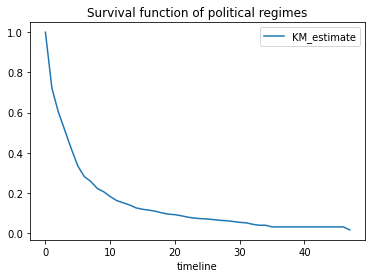

In [7]:
# Kaplan-Meier推定による生存関数をプロット
display(kmf.survival_function_.head())

kmf.survival_function_.plot()
plt.title("Survival function of political regimes")

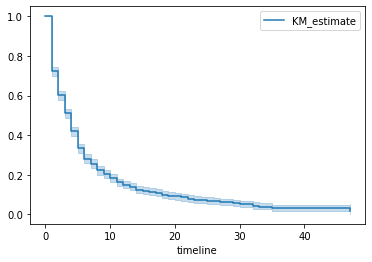

In [9]:
# 信頼区間も含めてプロット
kmf.plot()

In [18]:
# 在任期間の中央値(メディアン生存時間)
print(f'メディアン中央値: {kmf.median_survival_time_}')

print('メディアン中央値の95%信頼区間: ')
display(median_survival_times(kmf.confidence_interval_))

メディアン中央値: 4.0
メディアン中央値の95%信頼区間: 


,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.5,3.0,4.0


- 選出されたリーダーが4年以内に交代する可能性は50%以上

In [49]:
# 民主政権と非民主政権で層別
dem = []
for i in data['democracy'].values:
    if i=='Non-democracy':
        dem.append(0)
    elif i=='Democracy':
        dem.append(1)
dem = np.array(dem, dtype=bool)

In [51]:
dem

array([False, False, False, ..., False, False, False])

In [59]:
# 民主政権/非民主政権リーダーのKM識別器
# 特定の期間内の確率を推定するため、timeline引数を指定する
t = np.linspace(0, 50, 51)
dem_kmf = copy.copy(kmf.fit(T[dem], event_observed=E[dem], timeline=t, label='Democratuc Regimes'))
nondem_kmf = copy.copy(kmf.fit(T[~dem], event_observed=E[~dem], timeline=t, label='Non-democratuc Regimes'))

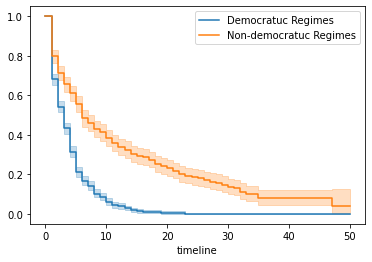

In [57]:
# 2群のKM曲線をプロット
ax = plt.subplot(111)
dem_kmf.plot(ax=ax)
nondem_kmf.plot(ax=ax)

- 非民主政権の方が在任機関長い
- 民主政権には、解任に至る原因として、「投票による解任」と「任期」が存在しこれらの影響と考えられる

In [67]:
# ログランク検定による2群のKM曲線の評価
## 有意水準を1%で設定
results = logrank_test(T[dem], T[~dem], E[dem], E[~dem], alpha=0.99)

display(results.print_summary())

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         260.47 <0.005    192.23

None

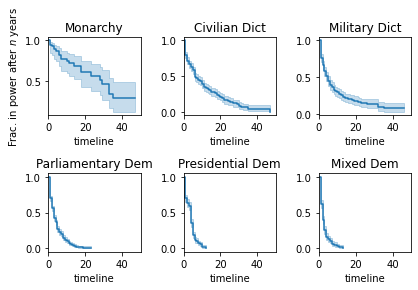

In [68]:
# 政権タイプ別にKM生存曲線を比較
regime_types = data['regime'].unique()

for i, regime_type in enumerate(regime_types):
    ax = plt.subplot(2, 3, i + 1)

    ix = data['regime'] == regime_type
    kmf.fit(T[ix], E[ix], label=regime_type)
    kmf.plot(ax=ax, legend=False)

    plt.title(regime_type)
    plt.xlim(0, 50)

    if i==0:
        plt.ylabel('Frac. in power after $n$ years')

plt.tight_layout()

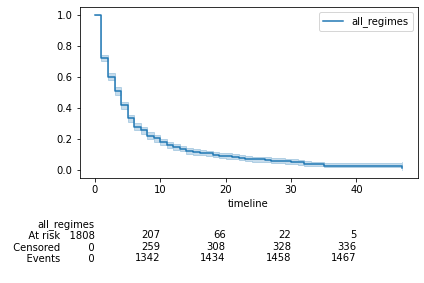

In [70]:
# KM曲線を作るときのベストプラクティス
## サマリテーブルと信頼区間を入れるべきと最新の研究では言われている
kmf = KaplanMeierFitter().fit(T, E, label="all_regimes")
kmf.plot(at_risk_counts=True) # サマリテーブルの追加
plt.tight_layout()